This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

In [15]:
import pandas as pd
import numpy as np
from collections import defaultdict 
import math
import json
import re
import time
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score,classification_report,recall_score, f1_score,average_precision_score,precision_score
import pickle
import joblib


sns.set_theme(style="whitegrid")
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


Exploration

In [16]:
#checking for outliers and Nans
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [17]:
# number of customers
profile.shape[0]

17000

In [18]:
#checking basic statistics
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


118    2175
101       5
Name: age, dtype: int64

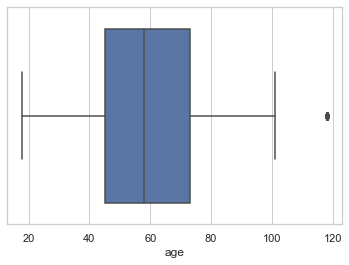

In [19]:
#checking for outliers and Nans
sns.boxplot(profile.age);
profile.age[profile.age > 100].value_counts()

In [20]:
#checking for outliers and Nans
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

Cleaning

In [21]:

def clean_portfolio(df):
    
    portfolio = df.copy()
    
    #extract channels
    channels = set()

    for label, value in portfolio["channels"].iteritems():
        for i in value:
            channels.add(i)

    #create dummy variables for channels
    for channel in channels:
        portfolio[channel] = portfolio["channels"].apply(lambda x: 1 if channel in x else 0)

    portfolio_cleaned = portfolio.drop("channels", axis =1).rename(columns={"id":"offer_id", 
                                                                            "offer_type":"offer_category"})
    
    #create new offer types to dinstinguish  
    portfolio_cleaned["offer_type"] = portfolio["offer_type"].str.cat(portfolio["reward"].astype(str), 
                                    sep='_').str.cat(portfolio["difficulty"].astype(str), 
                                                    sep ='_').str.cat(portfolio["duration"].astype(str),sep ='_')

    
    return  portfolio_cleaned

In [22]:
clean_portfolio(portfolio)

,reward,difficulty,duration,offer_category,offer_id,social,email,mobile,web,offer_type
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo_10_10_7
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_10_5
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0,1,1,1,informational_0_0_4
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,1,1,bogo_5_5_7
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,discount_5_20_10
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_7_7
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_10_10
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,informational_0_0_3
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_5_5
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,0,1,1,1,discount_2_10_7


In [23]:
def generate_person_ids():
    
    ids_old = profile.id.unique()
    ids_new = np.arange(1,profile.id.unique().shape[0]+1,1)
    ids_new = dict(zip(ids_old,ids_new))

    return ids_new

    


def clean_profile(df):
    
    profile = df.copy()

    #transform became_member_on column to datetime
    def transform_to_datetime(x):
        x = str(x)

        return datetime.date(int(x[:4]),int(x[4:6]),int(x[6:]))

    #create columns for year, quarter and day of membership start
    profile.became_member_on = pd.to_datetime(profile.became_member_on.transform(transform_to_datetime))
    profile["became_member_on_yr"] = profile["became_member_on"].dt.year
    profile["became_member_on_qtr"] = profile["became_member_on"].dt.quarter
    
    #simplify customer ids using integers
    profile.id = profile.id.map(generate_person_ids())
    
    
    
    #get dummies from gender column
    dummies_gender = pd.get_dummies(profile["gender"],  prefix="gender", prefix_sep='_',  dtype=int)
    profile = profile.merge(dummies_gender, left_index = True, right_index=True, how="outer")#.drop(["gender","became_member_on"], axis=1)


    profile_cleaned = profile

    
    return profile_cleaned

In [24]:
clean_profile(profile)

,gender,age,id,became_member_on,income,became_member_on_yr,became_member_on_qtr,gender_F,gender_M,gender_O
0,None,118,1,2017-02-12,NaN,2017,1,0,0,0
1,F,55,2,2017-07-15,112000.0,2017,3,1,0,0
2,None,118,3,2018-07-12,NaN,2018,3,0,0,0
3,F,75,4,2017-05-09,100000.0,2017,2,1,0,0
4,None,118,5,2017-08-04,NaN,2017,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...
16995,F,45,16996,2018-06-04,54000.0,2018,2,1,0,0
16996,M,61,16997,2018-07-13,72000.0,2018,3,0,1,0
16997,M,49,16998,2017-01-26,73000.0,2017,1,0,1,0
16998,F,83,16999,2016-03-07,50000.0,2016,1,1,0,0


In [25]:

def clean_transcript(df):
    
    transcript = df.copy()
    #clean transcript data
    transcript["offer_id"] = transcript.value.apply(lambda x: x[list(x.keys())[0]] if list(x.keys())[0]== 'offer id' or list(x.keys())[0] == 'offer_id' else np.nan)
    transcript["value"] = transcript.value.apply(lambda x: x[list(x.keys())[0]] if list(x.keys())[0]== 'amount' else np.nan)
    
    #simplify customer ids using integers
    transcript.person = transcript.person.map(generate_person_ids())

    transcript_cleaned = transcript
    
    return transcript_cleaned

In [26]:
clean_transcript(transcript)

,person,event,value,time,offer_id
0,4,offer received,NaN,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,5,offer received,NaN,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,6,offer received,NaN,0,2906b810c7d4411798c6938adc9daaa5
3,7,offer received,NaN,0,fafdcd668e3743c1bb461111dcafc2a4
4,8,offer received,NaN,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306529,16960,transaction,1.59,714,NaN
306530,16965,transaction,9.53,714,NaN
306531,16980,transaction,3.61,714,NaN
306532,16988,transaction,3.53,714,NaN


In [27]:

def merge_dataframes(df1=transcript, df2=profile, df3=portfolio):
    
    transcript = clean_transcript(df1.copy())
    profile = clean_profile(df2.copy())
    portfolio = clean_portfolio(df3.copy())
    

    #merge transcript with profile data
    df_merged = transcript.merge(profile, left_on="person", right_on="id", how="outer").drop(["id"], axis=1)
    
    #map offer types on ids
    df_merged["offer_type"] = df_merged["offer_id"].map(dict(zip(portfolio["offer_id"],portfolio["offer_type"])))
    df_merged["offer_category"] = df_merged["offer_id"].map(dict(zip(portfolio["offer_id"],portfolio["offer_category"])))
    
    #map rewards on value column
    reward = df_merged.offer_id.map(dict(zip(portfolio["offer_id"],portfolio["reward"])))
    df_merged["value"] = df_merged["value"].mask(df_merged["value"].isnull(),reward) 
    
    
    return df_merged

In [28]:
merge_dataframes()

,person,event,value,time,offer_id,gender,age,became_member_on,income,became_member_on_yr,became_member_on_qtr,gender_F,gender_M,gender_O,offer_type,offer_category
0,4,offer received,5.00,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,2017,2,1,0,0,bogo_5_5_7,bogo
1,4,offer viewed,5.00,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,2017,2,1,0,0,bogo_5_5_7,bogo
2,4,transaction,19.89,132,NaN,F,75,2017-05-09,100000.0,2017,2,1,0,0,NaN,NaN
3,4,offer completed,5.00,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,2017,2,1,0,0,bogo_5_5_7,bogo
4,4,transaction,17.78,144,NaN,F,75,2017-05-09,100000.0,2017,2,1,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,5105,offer received,10.00,576,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,2017-09-26,NaN,2017,3,0,0,0,bogo_10_10_5,bogo
306530,5105,offer viewed,10.00,594,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,2017-09-26,NaN,2017,3,0,0,0,bogo_10_10_5,bogo
306531,11904,offer received,10.00,576,4d5c57ea9a6940dd891ad53e9dbe8da0,F,58,2016-10-20,78000.0,2016,4,1,0,0,bogo_10_10_5,bogo
306532,11904,offer viewed,10.00,576,4d5c57ea9a6940dd891ad53e9dbe8da0,F,58,2016-10-20,78000.0,2016,4,1,0,0,bogo_10_10_5,bogo


In [ ]:
# event frequencies
customers_all = merge_dataframes(transcript, profile, portfolio)["event"]

customers_all.value_counts().plot.bar();

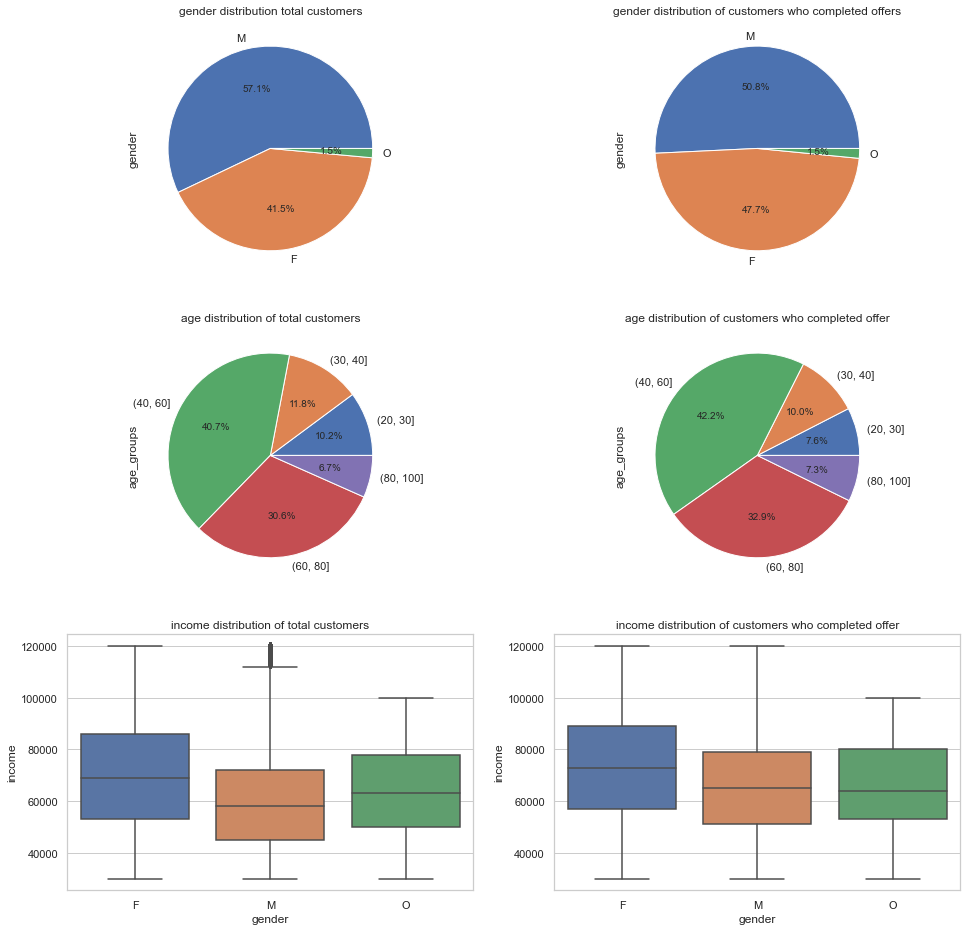

In [29]:
#compare demographic data of all vs customers that completed offers

#initializing figure 
fi, ax = plt.subplots(3,2, figsize=(16,16))
ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]
ax5 = ax[2][0]
ax6 = ax[2][1]

#initialize dataframes
customers_all = merge_dataframes(transcript, profile, portfolio).dropna(subset=['gender', 'income', "age"], axis =0)
customers_compl = customers_all[customers_all["event"]=="offer completed"][["person","age","gender","value","income","offer_type","offer_category"]].dropna()

#create age-brackets
age_groups_all  = pd.cut(customers_all['age'], [20,30,40,60,80,100],20).rename("age_groups").value_counts().sort_index(axis = 0)
age_groups_compl = pd.cut(customers_compl['age'], [20,30,40,60,80,100],20).rename("age_groups").value_counts().sort_index(axis = 0)


#compare gender distribution
ax1 = (customers_all.gender.value_counts() / customers_all.shape[0]).plot.pie( ax= ax1, autopct='%1.1f%%')
ax2 = (customers_compl.gender.value_counts() / customers_compl.shape[0]).plot.pie(ax= ax2, autopct='%1.1f%%')

#compare age distribution
ax3 = (age_groups_all / age_groups_all.sum()).plot.pie(ax= ax3, autopct='%1.1f%%')
ax4 =  (age_groups_compl / age_groups_compl.sum()).plot.pie(ax= ax4,autopct='%1.1f%%')


#compare income distribution
ax5 = sns.boxplot(x="gender", y="income", data=customers_all, ax=ax5)
ax6 = sns.boxplot(x="gender", y="income", data=customers_compl, ax=ax6)



#plot title
ax1.set_title('gender distribution total customers')
ax2.set_title('gender distribution of customers who completed offers')
ax3.set_title('age distribution of total customers')
ax4.set_title('age distribution of customers who completed offer');
ax5.set_title('income distribution of total customers')
ax6.set_title('income distribution of customers who completed offer');



Descriptive Statistics